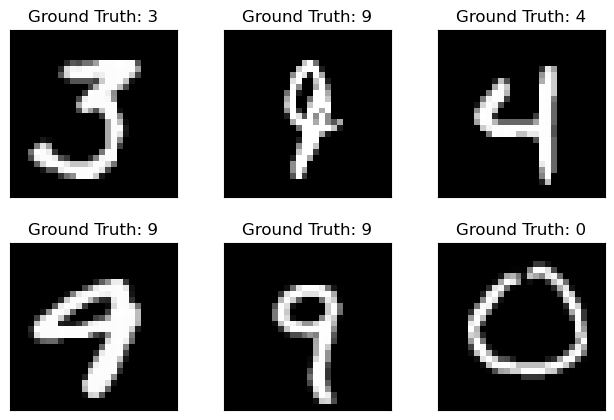

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.319280
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.290954
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.318535
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.261000
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.259137
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.229576
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.196151
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.181698
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.088444
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.014765
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.818550
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.822767
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.838672
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.530466
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.737049
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.419531
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.369398
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.343706
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.184050
Train Epoch: 1 [12160/60000 (20%)]	Loss: 1.061119
Train Epoch: 1 [12800/60000 (

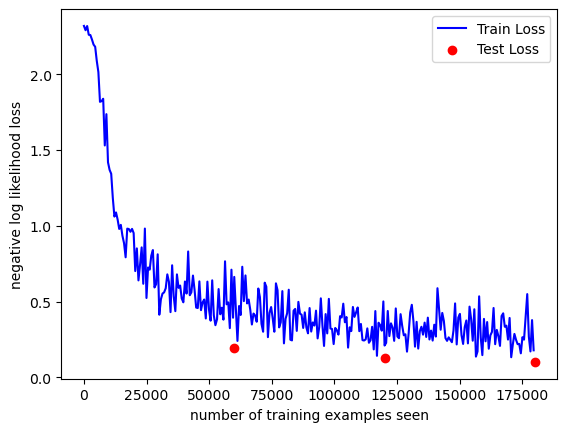

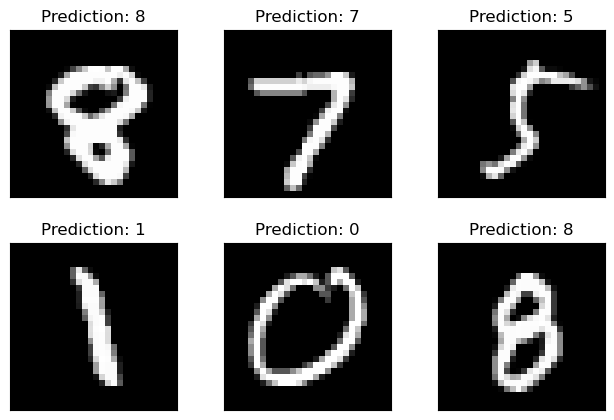

In [2]:
    import torch
    import torchvision
    from torch.utils.data import DataLoader
    import torch.nn as nn
    import torch.nn.functional as F
    import torch.optim as optim
    import matplotlib.pyplot as plt

n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10
random_seed = 1
torch.manual_seed(random_seed)

train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./data/', train=True, download=True,
                               transform=torchvision.transforms.Compose([
                                   torchvision.transforms.ToTensor(),
                                   torchvision.transforms.Normalize(
                                       (0.1307,), (0.3081,))
                               ])),
    batch_size=batch_size_train, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./data/', train=False, download=True,
                               transform=torchvision.transforms.Compose([
                                   torchvision.transforms.ToTensor(),
                                   torchvision.transforms.Normalize(
                                       (0.1307,), (0.3081,))
                               ])),
    batch_size=batch_size_test, shuffle=True)

examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
# print(example_targets)
# print(example_data.shape)

fig = plt.figure()
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])
plt.show()


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


network = Net()
optimizer = optim.SGD(network.parameters(),
                      lr=learning_rate, momentum=momentum)

train_losses = []
train_counter = []
test_losses = []
test_counter = [i * len(train_loader.dataset) for i in range(1, n_epochs + 1)]


def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = network(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch, batch_idx * len(data),
                                                                           len(train_loader.dataset),
                                                                           100. * batch_idx /
                                                                           len(train_loader),
                                                                           loss.item()))
            train_losses.append(loss.item())
            train_counter.append((batch_idx * 64) +
                                 ((epoch - 1) * len(train_loader.dataset)))
            torch.save(network.state_dict(), './model.pth')
            torch.save(optimizer.state_dict(), './optimizer.pth')


def test():
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = network(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


# train(1)

# test()  # 不加这个，后面画图就会报错：x and y must be the same size
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()


# fig = plt.figure()
# plt.plot(train_counter, train_losses, color='blue')
# plt.scatter(test_counter, test_losses, color='red')
# plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
# plt.xlabel('number of training examples seen')
# plt.ylabel('negative log likelihood loss')


# examples = enumerate(test_loader)
# batch_idx, (example_data, example_targets) = next(examples)
# with torch.no_grad():
#     output = network(example_data)
# fig = plt.figure()
# for i in range(6):
#     plt.subplot(2, 3, i + 1)
#     plt.tight_layout()
#     plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
#     plt.title("Prediction: {}".format(
#         output.data.max(1, keepdim=True)[1][i].item()))
#     plt.xticks([])
#     plt.yticks([])
# plt.show()


# ----------------------------------------------------------- #

# continued_network = Net()
# continued_optimizer = optim.SGD(
#     network.parameters(), lr=learning_rate, momentum=momentum)

# network_state_dict = torch.load('model.pth')
# continued_network.load_state_dict(network_state_dict)
# optimizer_state_dict = torch.load('optimizer.pth')
# continued_optimizer.load_state_dict(optimizer_state_dict)

# # 注意不要注释前面的“for epoch in range(1, n_epochs + 1):”部分，
# # 不然报错：x and y must be the same size
# # 为什么是“4”开始呢，因为n_epochs=3，上面用了[1, n_epochs + 1)
# for i in range(4, 9):
#     test_counter.append(i*len(train_loader.dataset))
#     train(i)
#     test()

# fig = plt.figure()
# plt.plot(train_counter, train_losses, color='blue')
# plt.scatter(test_counter, test_losses, color='red')
# plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
# plt.xlabel('number of training examples seen')
# plt.ylabel('negative log likelihood loss')
# plt.show()
